## 1. Set-up

In [1]:
import os, re
import random, math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
# IMAGE_SIZE = [180, 180]
IMAGE_SIZE = [270, 270]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/lms_project_dataset/EP11/train/*/*'
VAL_PATH = ROOT_PATH + '/lms_project_dataset/EP11/val/*/*'
TEST_PATH = ROOT_PATH + '/lms_project_dataset/EP11/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25
print(ROOT_PATH) # /aiffel/aiffel

/aiffel/aiffel


## 2. 데이터가져오기 

In [3]:
#데이터가져오기 
train_filenames = tf.io.gfile.glob(TRAIN_PATH) # 파일주소들이 리스트형태로 붙어있음.***
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
print(len(train_filenames)) # 5216
print(len(test_filenames)) # 624
print(len(val_filenames)) # 16

5216
624
16


In [4]:
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))
# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]
print(len(train_filenames))
print(len(val_filenames))
# 이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. 
#test_size를 수정하면 개수는 달라질 수 있습니다.

4185
1047


### 라벨분리

In [5]:
# 경로확인 
print(f'Normal image path\n{filenames[0]}') # /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person652_bacteria_2544.jpeg
print(f'Pneumonia image path\n{filenames[2000]}') # /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person156_virus_308.jpeg

Normal image path
/aiffel/aiffel/lms_project_dataset/EP11/train/PNEUMONIA/person1092_bacteria_3032.jpeg
Pneumonia image path
/aiffel/aiffel/lms_project_dataset/EP11/train/NORMAL/IM-0437-0001-0001.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}") #Normal images count in training set: 1089
# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}") # Pneumonia images count in training set: 3096
# "결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다." 

Normal images count in training set: 1063
Pneumonia images count in training set: 3122


### 배치처리작업 효율화 방법

In [7]:
# tf.data 인스턴스를 만들어 봅시다. 
#tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}") # Training images count: 4185 위에서부터 4185개
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}") # Validating images count: 1047 위에서부터 1047개

Training images count: 4185
Validating images count: 1047


In [8]:
# 라벨데이터 확인 
# 현재 이미지에는 라벨 데이터가 따로 없습니다.
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지 사이즈와 형식 바꿈, 
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다. 
# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져옴
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

#사이즈변환 및 라벨도 잘 들어가있음. 

Image shape:  (270, 270, 3)
Label:  True


In [12]:
# 위에서 train과 validation 데이터셋을 만든 것처럼 
# test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT) # 624
# Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.


624


In [13]:
# 밑에 있는 prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.
#shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
# repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
#예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.
# batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
# 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.
# prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


In [14]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
#     return ds
# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds) 

## 3. 데이터 시각화

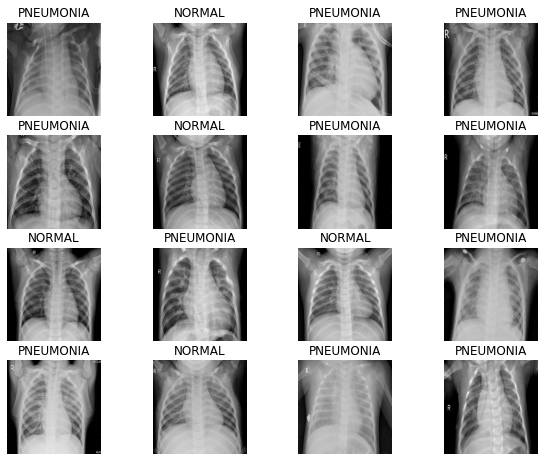

In [15]:
# 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [16]:
# 먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

In [17]:
# Dense Block은 아래와 같이 만듭니다.
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block


In [18]:
# 모델
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),  
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

## 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for NORMAL: {:.2f}'.format(weight_for_0)) # Weight for NORMAL: 1.91
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1)) # Weight for PNEUMONIA: 0.68

Weight for NORMAL: 1.97
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [20]:
# 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.
# 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
# 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.
with tf.device('/GPU:0'):
    model = build_model()
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
#모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 265s 989ms/step - loss: 0.5277 - accuracy: 0.7337 - precision: 0.9089 - recall: 0.7027 - val_loss: 0.8289 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 255s 977ms/step - loss: 0.2272 - accuracy: 0.9141 - precision: 0.9755 - recall: 0.9050 - val_loss: 1.2598 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 254s 973ms/step - loss: 0.2048 - accuracy: 0.9254 - precision: 0.9740 - recall: 0.9237 - val_loss: 0.2106 - val_accuracy: 0.9106 - val_precision: 0.8905 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 253s 969ms/step - loss: 0.1726 - accuracy: 0.9323 - precision: 0.9800 - recall: 0.9277 - val_loss: 0.7973 - val_accuracy: 0.6558 - val_precision: 1.0000 - val_recall: 0.5271
Epoch 5/25
261/261 [==============================] - 253s 969ms/step - loss: 0.1921 - a

## 7. 결과 확인 

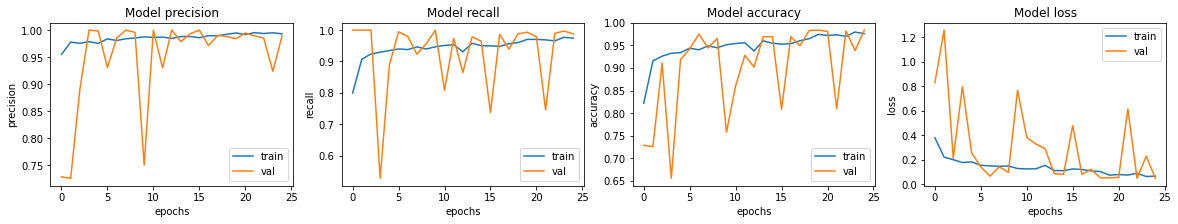

In [22]:
# 이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 10s 249ms/step - loss: 0.9750 - accuracy: 0.7644 - precision: 0.7288 - recall: 0.9923
Loss: 0.975016176700592,
Accuracy: 0.7644230723381042,
Precision: 0.7288135886192322,
Recall: 0.9923076629638672


## 프로젝트 정리
- 다양한 시도방법(배치사이즈, Data Augumentation 등)을 시도하였으나 좋은 결과가 나오지는 못한 것 같다. 
- 노드의 오리지널방법으로 하는 경우 아래와 같은 성과가 나온다. 
Loss: 1.3878273963928223,Accuracy: 0.7179487347602844,Precision: 0.6897163391113281,Recall: 0.9974358677864075
- 오리지널방법보다 좋았던 시도는 이미지사이즈를 [270,270]으로 올리는 것이었는데 훈련시간이 너무 오래 걸렸다. [360,360]으로도 시도하다가 시간상 테스트를 중단하였다. 이미지 사이즈를 올리니 loss가 줄고 정확도,Precision이 올라가면서 전반적인 성과가 개선되었다. 이미지가 갖고 있는 정보량이 늘어서 성과개선에 영향을 준 것으로 판단된다. 